# PLM Score vs Population Constraint Curves

This notebook explores the relationship between PLM (protein language model) predicted pathogenicity scores and observed/expected ratios from population data.

**Features:**
- Supports both **RGC** and **gnomAD** data sources
- Supports multiple prediction models: **Core**, **Complete**, **Constraint**
- Generates per-gene curves showing PLM score vs local O/E
- Overlays ClinVar pathogenic variants for validation
- **NEW: gnomAD-only dataset (gnomAD variants not observed in RGC) for model validation**
- **NEW: Generates browser-ready binned data for all 9 model-dataset combinations**
- **NEW: EDA comparing models and datasets**

**Objectives:**
1. Order missense variants by PLM score (from selected model)
2. Compute sliding window local O/E along this ordering
3. Plot the resulting curve (PLM score on x-axis, local O/E on y-axis)
4. Overlay ClinVar pathogenic variants
5. Characterize curve shapes and identify patterns across genes
6. **Export binned curve data for browser visualization**
7. **Compare models and datasets to understand model value**

## Step 1: Initialize Hail and Load Data

In [1]:
# =============================================================================
# CONFIGURATION - Modify these settings to switch data sources and models
# =============================================================================

# Data source: 'rgc' or 'gnomad'
# - rgc: RGC (Regeneron Genetics Center) variant data
# - gnomad: gnomAD v4 variant data
DATA_SOURCE = 'rgc'

# Prediction model: 'constraint', 'core', or 'complete'
# - constraint: Constraint-aware model (uses population constraint features)
# - core: Core features only (sequence-based, no structural features)
# - complete: Complete feature set (includes structural/AlphaFold features)
PREDICTION_MODEL = 'constraint'

# =============================================================================
# Path configuration - Update these paths for your environment
# =============================================================================
import yaml
import os

my_bucket = '/storage/zoghbi/home/u235147/merged_vars'

# Try to load from config file, fall back to defaults
config_path = '../config/paths.yaml'
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    DATA_PATHS = config['data_sources']
    HAIL_CONFIG = config.get('hail', {})
else:
    # Default paths (update for your environment)
    DATA_PATHS = {
        'rgc_scaled': f'{my_bucket}/rgc_scaled.ht',
        'gnomad_scaled': f'{my_bucket}/gnomadV4_scaled.ht',
        'predictions': '/local/Missense_Predictor_copy/Results/Inference/Predictions/AOU_RGC_All_preds.ht',
        'clinvar': '/storage/zoghbi/data/sharing/hail_tables/cv_38_final.ht',
    }
    HAIL_CONFIG = {'cpus': 40, 'tmpdir': '/local/tmp'}

# Prediction model column mapping (updated to match actual column names in predictions table)
PREDICTION_MODELS = {
    'constraint': 'Constraint_1000_General_aou_observed_neg4_pred',
    'core': 'Core_1000_General_aou_observed_neg4_pred',
    'complete': 'Complete_1000_General_aou_observed_neg4_pred'
}

# =============================================================================
# ALL COMBINATIONS - For browser data generation
# =============================================================================
ALL_MODELS = {
    'Constraint': 'Constraint_1000_General_aou_observed_neg4_pred',
    'Core': 'Core_1000_General_aou_observed_neg4_pred',
    'Complete': 'Complete_1000_General_aou_observed_neg4_pred'
}

# Datasets: RGC, gnomAD, and gnomAD-only (gnomAD variants not observed in RGC)
# gnomAD-only helps assess model performance on variants unseen in training data
ALL_DATASETS = {
    'RGC': f'{my_bucket}/rgc_scaled.ht',
    'gnomAD': f'{my_bucket}/gnomadV4_scaled.ht',
    'gnomAD-only': f'{my_bucket}/gnomadV4_scaled.ht',  # gnomAD with RGC-observed variants removed
}

# Browser output directory
BROWSER_OUTPUT_DIR = f'{my_bucket}/data/oe_curves'

# Validate configuration
assert DATA_SOURCE in ['rgc', 'gnomad'], f"Invalid DATA_SOURCE: {DATA_SOURCE}"
assert PREDICTION_MODEL in PREDICTION_MODELS, f"Invalid PREDICTION_MODEL: {PREDICTION_MODEL}"

print(f"Configuration:")
print(f"  Data Source: {DATA_SOURCE}")
print(f"  Prediction Model: {PREDICTION_MODEL}")
print(f"  PLM Score Column: {PREDICTION_MODELS[PREDICTION_MODEL]}")
print(f"\nBrowser output will include all 9 combinations (3 models x 3 datasets):")
for model in ALL_MODELS:
    for dataset in ALL_DATASETS:
        print(f"  - {model} + {dataset}")

Configuration:
  Data Source: rgc
  Prediction Model: constraint
  PLM Score Column: Constraint_1000_General_aou_observed_neg4_pred

Browser output will include all 9 combinations (3 models x 3 datasets):
  - Constraint + RGC
  - Constraint + gnomAD
  - Constraint + gnomAD-only
  - Core + RGC
  - Core + gnomAD
  - Core + gnomAD-only
  - Complete + RGC
  - Complete + gnomAD
  - Complete + gnomAD-only


In [2]:
import hail as hl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Hail configuration from config file or defaults
cpus = HAIL_CONFIG.get('cpus', 40)
tmpdir = HAIL_CONFIG.get('tmpdir', '/local/tmp')
memory = int(3600 * cpus / 256)

spark_config = {
    'spark.driver.memory': f'{memory}g',
    'spark.executor.memory': f'{memory}g',
    'spark.local.dir': tmpdir,
    'spark.ui.enabled': 'false'
}

hl.init(spark_conf=spark_config, master=f'local[{cpus}]', tmp_dir=tmpdir, local_tmpdir=tmpdir)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Set paths based on DATA_SOURCE configuration
if DATA_SOURCE == 'rgc':
    main_ht_path = DATA_PATHS['rgc_scaled']
elif DATA_SOURCE == 'gnomad':
    main_ht_path = DATA_PATHS['gnomad_scaled']
    
plm_ht_path = DATA_PATHS['predictions']
clinvar_path = DATA_PATHS['clinvar']

# Output directory - include data source and model in name
output_dir = f'../output/curve_data/{DATA_SOURCE}_{PREDICTION_MODEL}'

print(f"\nPaths configured:")
print(f"  Main variant table: {main_ht_path}")
print(f"  Predictions table: {plm_ht_path}")
print(f"  ClinVar table: {clinvar_path}")
print(f"  Output directory: {output_dir}")

Loading BokehJS ...

Running on Apache Spark version 3.5.4
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.134-952ae203dbbe
LOGGING: writing to /storage/zoghbi/home/u235147/VarPredBrowser/notebooks/hail-20260105-2107-0.2.134-952ae203dbbe.log



Paths configured:
  Main variant table: /storage/zoghbi/home/u235147/merged_vars/rgc_scaled.ht
  Predictions table: /local/Missense_Predictor_copy/Results/Inference/Predictions/AOU_RGC_All_preds.ht
  ClinVar table: /storage/zoghbi/data/sharing/hail_tables/cv_38_final.ht
  Output directory: ../output/curve_data/rgc_constraint


2026-01-05 21:07:59.393 Hail: INFO: Coerced sorted dataset
2026-01-05 21:08:23.931 Hail: INFO: wrote table with 72174760 rows in 226 partitions to /local/tmp/eda_step1_missense_rgc_constraint.ht
2026-01-05 21:08:36.878 Hail: INFO: wrote table with 64145 rows in 1 partition to /local/tmp/__iruid_105-hmFBu0DPrmuRJ4aK0FOU8Y
2026-01-05 21:08:44.051 Hail: INFO: wrote table with 72174760 rows in 226 partitions to /local/tmp/eda_step2_with_clinvar.ht
2026-01-05 21:10:19.062 Hail: INFO: wrote table with 72175695 rows in 40 partitions to /local/tmp/base_RGC.ht
2026-01-05 21:12:24.863 Hail: INFO: wrote table with 72175695 rows in 40 partitions to /local/tmp/base_gnomAD.ht
2026-01-05 21:16:53.198 Hail: INFO: wrote table with 61731442 rows in 40 partitions to /local/tmp/base_gnomAD-only.ht
2026-01-05 21:17:10.933 Hail: INFO: Coerced sorted dataset
2026-01-05 21:17:30.481 Hail: INFO: wrote table with 72174760 rows in 40 partitions to /local/tmp/opt_Constraint_RGC_plm.ht
2026-01-05 21:17:39.873 Hail

In [3]:
# Create output directory
import os
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f'{output_dir}/gene_plots', exist_ok=True)

In [4]:
# Load PLM predictions and check structure
plm_ht = hl.read_table(plm_ht_path)
print("PLM predictions structure:")
plm_ht.describe()

PLM predictions structure:
----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'ID_38': str 
    'genename': str 
    'alleles': array<str> 
    'Ensembl_transcriptid': str 
    'aapos': int32 
    'aaref': str 
    'Uniprot_acc': str 
    'aaalt': str 
    'plddt_lt_60': bool 
    'Constraint_1000_General_aou_observed_neg4_pred': float32 
    'Constraint_1000_General_aou_observed_neg4_pred_std': float32 
    'Constraint_1000_General_aou_observed_neg4_label': float32 
    'Constraint_1000_General_aou_observed_neg4_n_pred': int32 
    'Core_1000_General_aou_observed_neg4_pred': float32 
    'Core_1000_General_aou_observed_neg4_pred_std': float32 
    'Core_1000_General_aou_observed_neg4_label': float32 
    'Core_1000_General_aou_observed_neg4_n_pred': int32 
    'Complete_1000_General_aou_observed_neg4_pred': float32 
    'Complete_1000_General_aou_observed_neg4_pred_std': float32 
    'Complete_1000_General_aou_obse

In [5]:
# Load main variant table
main_ht = hl.read_table(main_ht_path)
print("Main variant table structure:")
main_ht.describe()

Main variant table structure:
----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'region': str 
    'roulette_AR_MR': float64 
    'aa_pos': int32 
    'most_deleterious_consequence': str 
    'most_deleterious_consequence_cds': str 
    'gnomadV4_exomes_coverage': struct {
        mean: float64, 
        median_approx: int32, 
        total_DP: int64, 
        over_1: float64, 
        over_5: float64, 
        over_10: float64, 
        over_15: float64, 
        over_20: float64, 
        over_25: float64, 
        over_30: float64, 
        over_50: float64, 
        over_100: float64
    } 
    'gnomadV4_genomes_coverage': struct {
        mean: float64, 
        median_approx: int32, 
        total_DP: int64, 
        over_1: float32, 
        over_5: float32, 
        over_10: float32, 
        over_15: float32, 
        over_20: float32, 
        over_25

## Step 2: Join Tables and Filter to Missense Variants

In [6]:
# Join PLM scores to main table
# The PLM table has locus and alleles but is not keyed by default
print("PLM table fields:", [f for f in plm_ht.row])
print("Main table key:", main_ht.key)

# Key PLM table by locus and alleles for joining
plm_ht = plm_ht.key_by('locus', 'alleles')
print("PLM table now keyed by:", plm_ht.key)

# Get the PLM score column name from configuration
plm_score_col = PREDICTION_MODELS[PREDICTION_MODEL]
print(f"\nUsing prediction model: {PREDICTION_MODEL}")
print(f"PLM score column: {plm_score_col}")

# Join PLM scores - using the configured prediction model
main_ht = main_ht.annotate(
    plm_score = plm_ht[main_ht.locus, main_ht.alleles][plm_score_col]
)

# Filter to missense variants with valid data
# Note: Both RGC and gnomAD tables use the same column names for XX_XY exomes
missense_ht = main_ht.filter(
    (main_ht.most_deleterious_consequence_cds == 'missense_variant') &
    hl.is_defined(main_ht.plm_score) &
    hl.is_defined(main_ht.roulette_AR_MR_scaled_exomes_XX_XY) &
    (main_ht.roulette_AR_MR_scaled_exomes_XX_XY > 0)
)

# Extract transcript ID from region
missense_ht = missense_ht.annotate(
    transcript = missense_ht.region.split('-')[0]
)

# Checkpoint for efficiency
missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step1_missense_{DATA_SOURCE}_{PREDICTION_MODEL}.ht', overwrite=True)
print(f"\nFiltered missense variants with PLM scores: {missense_ht.count():,}")
print(f"Data source: {DATA_SOURCE}, Prediction model: {PREDICTION_MODEL}")

PLM table fields: ['ID_38', 'genename', 'alleles', 'Ensembl_transcriptid', 'aapos', 'aaref', 'Uniprot_acc', 'aaalt', 'plddt_lt_60', 'Constraint_1000_General_aou_observed_neg4_pred', 'Constraint_1000_General_aou_observed_neg4_pred_std', 'Constraint_1000_General_aou_observed_neg4_label', 'Constraint_1000_General_aou_observed_neg4_n_pred', 'Core_1000_General_aou_observed_neg4_pred', 'Core_1000_General_aou_observed_neg4_pred_std', 'Core_1000_General_aou_observed_neg4_label', 'Core_1000_General_aou_observed_neg4_n_pred', 'Complete_1000_General_aou_observed_neg4_pred', 'Complete_1000_General_aou_observed_neg4_pred_std', 'Complete_1000_General_aou_observed_neg4_label', 'Complete_1000_General_aou_observed_neg4_n_pred', 'Complete_200_plddt_weighted_pu_10_np_General_aou_observed_neg4_pred', 'Complete_200_plddt_weighted_pu_10_np_General_aou_observed_neg4_pred_std', 'Complete_200_plddt_weighted_pu_10_np_General_aou_observed_neg4_label', 'Complete_200_plddt_weighted_pu_10_np_General_aou_observed_ne


Filtered missense variants with PLM scores: 72,174,760
Data source: rgc, Prediction model: constraint


## Step 3: Extract ClinVar Pathogenic Variants

In [7]:
def get_valid_origin_sums():
    """Calculate all valid origin code sums (excluding somatic-only=2)."""
    origin_codes = [0, 1, 2, 4, 8, 16, 32, 256]
    all_sums = set()
    for r in range(1, len(origin_codes) + 1):
        for combo in combinations(origin_codes, r):
            all_sums.add(sum(combo))
    return sorted([s for s in all_sums if s != 2])

def extract_pathogenic_variants(clinvar_path):
    """
    Extract filtered pathogenic missense variants from ClinVar.
    
    Note: ClinVar fields are nested under 'clinvar_38' struct.
    MC field contains molecular consequence - we filter to missense_variant.
    """
    clinvar = hl.read_table(clinvar_path)
    
    # Check structure
    print("ClinVar table structure:")
    clinvar.describe()
    
    valid_origins = get_valid_origin_sums()
    valid_origins_set = hl.set([str(i) for i in valid_origins])
    
    # Access nested fields under clinvar_38
    cv = clinvar.clinvar_38

    # Filter 1: Pathogenic missense variants
    # MC is an array of molecular consequences
    path_ht = clinvar.filter(
        hl.any(lambda mc: mc.contains('missense_variant'), cv.MC) &
        hl.any(lambda sig: sig.matches("athogenic"), cv.CLNSIG)  # matches Pathogenic or Likely_pathogenic
    )
    print(f"After pathogenic missense filter: {path_ht.count()}")

    # Filter 2: Valid germline origin (exclude somatic-only)
    path_ht = path_ht.filter(
        hl.any(lambda origin: valid_origins_set.contains(origin), path_ht.clinvar_38.ORIGIN)
    )
    print(f"After origin filter: {path_ht.count()}")

    # Filter 3: Exclude conflicting interpretations
    path_ht = path_ht.filter(
        ~hl.any(lambda sig: sig.contains("Conflicting"), path_ht.clinvar_38.CLNSIG)
    )
    print(f"After excluding conflicting: {path_ht.count()}")

    return path_ht

# Extract ClinVar pathogenic variants
clinvar_ht = extract_pathogenic_variants(clinvar_path)
# Table is already keyed by locus, alleles based on the schema
print(f"ClinVar table key: {clinvar_ht.key}")

ClinVar table structure:
----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'clinvar_38': struct {
        rsid: str, 
        AF_ESP: float64, 
        AF_EXAC: float64, 
        AF_TGP: float64, 
        ALLELEID: int32, 
        CLNDN: array<str>, 
        CLNDNINCL: array<str>, 
        CLNDISDB: array<str>, 
        CLNDISDBINCL: array<str>, 
        CLNHGVS: array<str>, 
        CLNREVSTAT: array<str>, 
        CLNSIG: array<str>, 
        CLNSIGCONF: array<str>, 
        CLNSIGINCL: array<str>, 
        CLNSIGSCV: array<str>, 
        CLNVC: str, 
        CLNVCSO: str, 
        CLNVI: array<str>, 
        DBVARID: array<str>, 
        GENEINFO: str, 
        MC: array<str>, 
        ONCDN: array<str>, 
        ONCDNINCL: array<str>, 
        ONCDISDB: array<str>, 
        ONCDISDBINCL: array<str>, 
        ONC: array<str>, 
        ONCINCL: array<str>, 
 

After pathogenic missense filter: 158001


After origin filter: 156922


After excluding conflicting: 64145
ClinVar table key: <StructExpression of type struct{locus: locus<GRCh38>, alleles: array<str>}>


In [8]:
# Annotate missense variants with ClinVar status
# ClinVar table is already keyed by locus, alleles
missense_ht = missense_ht.annotate(
    is_clinvar_pathogenic = hl.is_defined(clinvar_ht[missense_ht.locus, missense_ht.alleles])
)

missense_ht = missense_ht.checkpoint(f'{tmpdir}/eda_step2_with_clinvar.ht', overwrite=True)

n_clinvar = missense_ht.aggregate(hl.agg.count_where(missense_ht.is_clinvar_pathogenic))
print(f"ClinVar P/LP missense variants in dataset: {n_clinvar:,}")

ClinVar P/LP missense variants in dataset: 61,463


## Step 4: Generate Browser Data (All 9 Model-Dataset Combinations)

This section generates pre-computed O/E curve data for all combinations of:
- **Models**: Constraint, Core, Complete
- **Datasets**: RGC, gnomAD, gnomAD-only

The gnomAD-only dataset contains gnomAD variants NOT observed in RGC, which helps assess model performance on variants from an independent population (unseen during training).

In [9]:
# Create browser output directory
import os
os.makedirs(BROWSER_OUTPUT_DIR, exist_ok=True)
print(f"Browser output directory: {BROWSER_OUTPUT_DIR}")

Browser output directory: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves


In [10]:
from datetime import datetime
import os

def log_progress(step, message):
    """Helper for timestamped logging."""
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {step}: {message}")

def process_model_dataset_combination(model_name, model_col, dataset_name, dataset_path, plm_ht, clinvar_ht, tmpdir, gnomad_ht=None):
    """
    Process a single model + dataset combination and return curve data.
    
    Args:
        model_name: Name of the model (Constraint, Core, Complete)
        model_col: Column name in predictions table
        dataset_name: Name of the dataset (RGC, gnomAD, RGC-only)
        dataset_path: Path to the dataset
        plm_ht: PLM predictions table (keyed)
        clinvar_ht: ClinVar pathogenic variants table (keyed)
        tmpdir: Temporary directory for checkpoints
        gnomad_ht: gnomAD table for filtering RGC-only (optional)
    
    Returns path to output parquet file.
    """
    log_progress("START", f"Processing: {model_name} + {dataset_name}")
    print(f"{'='*60}")
    
    # Load dataset
    log_progress("1/8", f"Loading dataset from {dataset_path}...")
    main_ht = hl.read_table(dataset_path)
    
    # For RGC-only: filter out variants that appear in gnomAD
    if dataset_name == 'RGC-only' and gnomad_ht is not None:
        log_progress("1b/8", "Filtering out gnomAD-observed variants...")
        n_before = main_ht.count()
        main_ht = main_ht.filter(~hl.is_defined(gnomad_ht[main_ht.locus, main_ht.alleles]))
        n_after = main_ht.count()
        print(f"    Before: {n_before:,} -> After: {n_after:,} ({100*n_after/n_before:.1f}% retained)")
    
    # Join PLM scores using the model-specific column
    log_progress("2/8", f"Joining PLM scores using column: {model_col}")
    main_ht = main_ht.annotate(
        plm_score = plm_ht[main_ht.locus, main_ht.alleles][model_col]
    )
    
    # Filter to missense variants with valid data
    log_progress("3/8", "Filtering to missense variants...")
    missense_ht = main_ht.filter(
        (main_ht.most_deleterious_consequence_cds == 'missense_variant') &
        hl.is_defined(main_ht.plm_score) &
        hl.is_defined(main_ht.roulette_AR_MR_scaled_exomes_XX_XY) &
        (main_ht.roulette_AR_MR_scaled_exomes_XX_XY > 0)
    )
    
    # Extract transcript ID and gene symbol from region
    missense_ht = missense_ht.annotate(
        transcript = missense_ht.region.split('-')[0],
        gene_symbol = missense_ht.region.split('-')[1]
    )
    
    # Annotate with ClinVar status
    missense_ht = missense_ht.annotate(
        is_clinvar_pathogenic = hl.is_defined(clinvar_ht[missense_ht.locus, missense_ht.alleles])
    )
    
    # Checkpoint
    checkpoint_path = f'{tmpdir}/browser_{model_name}_{dataset_name}_missense.ht'
    missense_ht = missense_ht.checkpoint(checkpoint_path, overwrite=True)
    n_variants = missense_ht.count()
    log_progress("3b/8", f"Checkpointed {n_variants:,} missense variants")
    
    # Order by transcript + PLM score
    log_progress("4/8", "Ordering by transcript and PLM score...")
    missense_ht = missense_ht.order_by('transcript', 'plm_score')
    
    # Add index and detect transcript boundaries
    missense_ht = missense_ht.annotate(
        __idx=hl.scan.count(),
        __prev_transcript=hl.scan.fold(
            hl.missing(hl.tstr),
            lambda acc: missense_ht.transcript,
            lambda a, b: b
        )
    )
    
    missense_ht = missense_ht.annotate(
        __transcript_match=hl.if_else(
            (missense_ht.__prev_transcript == missense_ht.transcript) | hl.is_missing(missense_ht.__prev_transcript),
            1, 0
        )
    )
    
    # Build neighbor arrays (MAX_WINDOW on each side)
    MAX_WINDOW = 150
    MIN_EXPECTED = 10.0
    neighbor_struct = hl.tstruct(obs=hl.tint32, exp=hl.tfloat64)
    empty_neighbors = hl.empty_array(neighbor_struct)
    
    # Forward pass (descending): collect "following" neighbors
    log_progress("5/8", "Building following neighbor arrays (forward pass)...")
    missense_ht = missense_ht.order_by(hl.desc(missense_ht.__idx))
    missense_ht = missense_ht.annotate(
        __following=hl.scan.fold(
            empty_neighbors,
            lambda acc: hl.if_else(
                missense_ht.__transcript_match == 0,
                empty_neighbors,
                hl.array([hl.struct(
                    obs=missense_ht.binary_presence_exomes_XX_XY,
                    exp=missense_ht.roulette_AR_MR_scaled_exomes_XX_XY
                )]).extend(acc)[:MAX_WINDOW]
            ),
            lambda a, b: b
        )
    )
    
    missense_ht = missense_ht.checkpoint(f'{tmpdir}/browser_{model_name}_{dataset_name}_following.ht', overwrite=True)
    log_progress("5b/8", "Checkpointed following arrays")
    
    # Backward pass: collect "previous" neighbors
    log_progress("6/8", "Building previous neighbor arrays (backward pass)...")
    missense_ht = missense_ht.order_by(hl.asc(missense_ht.__idx))
    missense_ht = missense_ht.annotate(
        __previous=hl.scan.fold(
            empty_neighbors,
            lambda acc: hl.if_else(
                missense_ht.__transcript_match == 0,
                empty_neighbors,
                hl.array([hl.struct(
                    obs=missense_ht.binary_presence_exomes_XX_XY,
                    exp=missense_ht.roulette_AR_MR_scaled_exomes_XX_XY
                )]).extend(acc)[:MAX_WINDOW]
            ),
            lambda a, b: b
        )
    )
    
    missense_ht = missense_ht.checkpoint(f'{tmpdir}/browser_{model_name}_{dataset_name}_previous.ht', overwrite=True)
    log_progress("6b/8", "Checkpointed previous arrays")
    
    # Compute local O/E
    log_progress("7/8", "Computing local O/E...")
    missense_ht = missense_ht.annotate(
        __all_values=missense_ht.__previous[::-1].extend(
            hl.array([hl.struct(
                obs=missense_ht.binary_presence_exomes_XX_XY,
                exp=missense_ht.roulette_AR_MR_scaled_exomes_XX_XY
            )])
        ).extend(missense_ht.__following)
    )
    
    missense_ht = missense_ht.annotate(
        window_obs=hl.sum(missense_ht.__all_values.map(lambda x: x.obs)),
        window_exp=hl.sum(missense_ht.__all_values.map(lambda x: x.exp)),
        window_size=hl.len(missense_ht.__all_values)
    )
    
    missense_ht = missense_ht.annotate(
        local_oe=hl.if_else(
            missense_ht.window_exp >= MIN_EXPECTED,
            missense_ht.window_obs / missense_ht.window_exp,
            hl.missing(hl.tfloat64)
        )
    )
    
    # Select output columns (key_by() drops __idx key before select)
    output_ht = missense_ht.key_by().select(
        'transcript',
        'gene_symbol',
        'plm_score',
        'local_oe',
        'is_clinvar_pathogenic',
        'window_obs',
        'window_exp',
        'window_size'
    )
    
    # Export to parquet
    output_path = f'{BROWSER_OUTPUT_DIR}/raw_{model_name}_{dataset_name}.parquet'
    log_progress("8/8", f"Writing to {output_path}...")
    
    # Count rows before writing to ensure data exists
    row_count = output_ht.count()
    log_progress("8a/8", f"About to write {row_count:,} rows")
    
    output_ht.to_spark().write.mode('overwrite').parquet(output_path)
    
    # Verify the write succeeded
    if os.path.exists(output_path):
        log_progress("DONE", f"SUCCESS: {output_path} exists")
    else:
        log_progress("ERROR", f"FAILED: {output_path} does NOT exist!")
        raise RuntimeError(f"Parquet write failed - file does not exist: {output_path}")
    
    return output_path

In [11]:
# Load PLM predictions table (keyed for joining)
print("Loading PLM predictions table...")
plm_ht_browser = hl.read_table(DATA_PATHS['predictions'])
plm_ht_browser = plm_ht_browser.key_by('locus', 'alleles')

# Load ClinVar table (already keyed)
print("Loading ClinVar table...")
clinvar_ht_browser = extract_pathogenic_variants(DATA_PATHS['clinvar'])

# Load RGC table for gnomAD-only filtering (need binary_presence to identify observed variants)
# RGC and gnomAD tables contain the same positions - the difference is which are observed
print("Loading RGC table for gnomAD-only filtering...")
rgc_ht_browser = hl.read_table(ALL_DATASETS['RGC'])
rgc_ht_browser = rgc_ht_browser.select('binary_presence_exomes_XX_XY')  # Keep observed status for filtering
print(f"RGC table loaded with {rgc_ht_browser.count():,} variants")

print("\nReady to process all 9 combinations (3 models x 3 datasets).")

Loading PLM predictions table...
Loading ClinVar table...
ClinVar table structure:
----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'clinvar_38': struct {
        rsid: str, 
        AF_ESP: float64, 
        AF_EXAC: float64, 
        AF_TGP: float64, 
        ALLELEID: int32, 
        CLNDN: array<str>, 
        CLNDNINCL: array<str>, 
        CLNDISDB: array<str>, 
        CLNDISDBINCL: array<str>, 
        CLNHGVS: array<str>, 
        CLNREVSTAT: array<str>, 
        CLNSIG: array<str>, 
        CLNSIGCONF: array<str>, 
        CLNSIGINCL: array<str>, 
        CLNSIGSCV: array<str>, 
        CLNVC: str, 
        CLNVCSO: str, 
        CLNVI: array<str>, 
        DBVARID: array<str>, 
        GENEINFO: str, 
        MC: array<str>, 
        ONCDN: array<str>, 
        ONCDNINCL: array<str>, 
        ONCDISDB: array<str>, 
        ONCDISDBINCL: array<str>, 

After pathogenic missense filter: 158001


After origin filter: 156922


After excluding conflicting: 64145
Loading RGC table for gnomAD-only filtering...
RGC table loaded with 817,452,381 variants

Ready to process all 9 combinations (3 models x 3 datasets).


In [12]:
# =============================================================================
# OPTIMIZATION: Prepare base datasets (one per dataset, reused for all models)
# =============================================================================
# This reduces redundant computation: instead of loading/filtering each dataset 
# 3 times (once per model), we do it once and reuse for all 3 models.

def prepare_dataset_base(dataset_name, dataset_path, clinvar_ht, rgc_ht=None):
    """
    Prepare base dataset with all shared annotations (done ONCE per dataset).
    Returns checkpointed table ready for PLM score joining.
    
    Args:
        dataset_name: Name of the dataset (RGC, gnomAD, gnomAD-only)
        dataset_path: Path to the dataset
        clinvar_ht: ClinVar pathogenic variants table (keyed)
        rgc_ht: RGC table for gnomAD-only filtering (contains binary_presence_exomes_XX_XY)
    """
    log_progress("BASE", f"Preparing base dataset: {dataset_name}")
    print(f"{'='*60}")

    # Load dataset
    log_progress("BASE-1", f"Loading from {dataset_path}")
    main_ht = hl.read_table(dataset_path)

    # For gnomAD-only: keep variants that are NOT observed in RGC
    # This includes both gnomAD-observed and gnomAD-unobserved variants
    # so the O/E calculation remains valid (needs mix of observed/unobserved)
    if dataset_name == 'gnomAD-only' and rgc_ht is not None:
        log_progress("BASE-2", "Filtering to RGC-unobserved variants (gnomAD-only)")
        n_before = main_ht.count()
        
        # Join with RGC to get RGC observed status
        main_ht = main_ht.annotate(
            rgc_observed = rgc_ht[main_ht.locus, main_ht.alleles].binary_presence_exomes_XX_XY
        )
        
        # Keep variants that are NOT observed in RGC (rgc_observed == 0 or missing)
        # Do NOT filter on gnomAD binary_presence - we need both observed and unobserved
        # variants for valid O/E calculation
        main_ht = main_ht.filter(
            (main_ht.rgc_observed == 0) | hl.is_missing(main_ht.rgc_observed)
        )
        
        n_after = main_ht.count()
        print(f"    Filtered: {n_before:,} -> {n_after:,} ({100*n_after/n_before:.1f}% retained)")

    # Filter to missense with valid expected values (PLM filter happens later per-model)
    log_progress("BASE-3", "Filtering to missense variants")
    missense_ht = main_ht.filter(
        (main_ht.most_deleterious_consequence_cds == 'missense_variant') &
        hl.is_defined(main_ht.roulette_AR_MR_scaled_exomes_XX_XY) &
        (main_ht.roulette_AR_MR_scaled_exomes_XX_XY > 0)
    )

    # Repartition after filtering to balance partitions
    # ~70M missense variants -> 40 partitions = ~1.75M per partition
    log_progress("BASE-3b", "Repartitioning to 40 balanced partitions")
    missense_ht = missense_ht.repartition(40)

    # Add shared annotations
    log_progress("BASE-4", "Adding transcript, gene_symbol, ClinVar annotations")
    missense_ht = missense_ht.annotate(
        transcript = missense_ht.region.split('-')[0],
        gene_symbol = missense_ht.region.split('-')[1],
        is_clinvar_pathogenic = hl.is_defined(clinvar_ht[missense_ht.locus, missense_ht.alleles])
    )

    # CHECKPOINT - This is reused for all 3 models
    checkpoint_path = f'{tmpdir}/base_{dataset_name}.ht'
    missense_ht = missense_ht.checkpoint(checkpoint_path, overwrite=True)
    n_variants = missense_ht.count()
    log_progress("BASE-DONE", f"Checkpointed {n_variants:,} variants to {checkpoint_path}")

    return missense_ht

# Prepare base datasets (3 datasets, done ONCE each)
print("="*60)
print("OPTIMIZATION: Preparing base datasets (3 datasets)")
print("Each will be reused for all 3 models, saving ~30% runtime")
print("="*60)

base_datasets = {}
for dataset_name, dataset_path in ALL_DATASETS.items():
    base_datasets[dataset_name] = prepare_dataset_base(
        dataset_name=dataset_name,
        dataset_path=dataset_path,
        clinvar_ht=clinvar_ht_browser,
        rgc_ht=rgc_ht_browser if dataset_name == 'gnomAD-only' else None
    )
    print()

print("="*60)
print(f"Base datasets prepared: {list(base_datasets.keys())}")
print("="*60)

OPTIMIZATION: Preparing base datasets (3 datasets)
Each will be reused for all 3 models, saving ~30% runtime
[21:08:55] BASE: Preparing base dataset: RGC
[21:08:55] BASE-1: Loading from /storage/zoghbi/home/u235147/merged_vars/rgc_scaled.ht
[21:08:55] BASE-3: Filtering to missense variants
[21:08:55] BASE-3b: Repartitioning to 40 balanced partitions
[21:08:55] BASE-4: Adding transcript, gene_symbol, ClinVar annotations


[21:10:19] BASE-DONE: Checkpointed 72,175,695 variants to /local/tmp/base_RGC.ht

[21:10:19] BASE: Preparing base dataset: gnomAD
[21:10:19] BASE-1: Loading from /storage/zoghbi/home/u235147/merged_vars/gnomadV4_scaled.ht
[21:10:19] BASE-3: Filtering to missense variants
[21:10:19] BASE-3b: Repartitioning to 40 balanced partitions
[21:10:19] BASE-4: Adding transcript, gene_symbol, ClinVar annotations


[21:12:24] BASE-DONE: Checkpointed 72,175,695 variants to /local/tmp/base_gnomAD.ht

[21:12:24] BASE: Preparing base dataset: gnomAD-only
[21:12:24] BASE-1: Loading from /storage/zoghbi/home/u235147/merged_vars/gnomadV4_scaled.ht
[21:12:25] BASE-2: Filtering to RGC-unobserved variants (gnomAD-only)


    Filtered: 817,452,381 -> 800,879,388 (98.0% retained)
[21:12:49] BASE-3: Filtering to missense variants
[21:12:49] BASE-3b: Repartitioning to 40 balanced partitions
[21:12:49] BASE-4: Adding transcript, gene_symbol, ClinVar annotations


[21:16:53] BASE-DONE: Checkpointed 61,731,442 variants to /local/tmp/base_gnomAD-only.ht

Base datasets prepared: ['RGC', 'gnomAD', 'gnomAD-only']


In [13]:
# =============================================================================
# OPTIMIZED: Process model on pre-prepared base dataset
# =============================================================================
# This function is much faster because dataset loading, missense filtering,
# and ClinVar annotation are already done in the base dataset.

def process_model_on_base(base_ht, model_name, model_col, dataset_name, plm_ht):
    """
    Process a single model on a pre-prepared base dataset.
    Much faster since base filtering/annotation is already done.
    """
    log_progress("MODEL", f"Processing model: {model_name} on {dataset_name}")
    
    # Join PLM scores (the only model-specific step before windowing)
    log_progress("MODEL-1", f"Joining PLM scores using column: {model_col}")
    ht = base_ht.annotate(plm_score = plm_ht[base_ht.locus, base_ht.alleles][model_col])
    
    # Filter to variants with valid PLM scores
    log_progress("MODEL-2", "Filtering to variants with PLM scores")
    ht = ht.filter(hl.is_defined(ht.plm_score))
    
    # Checkpoint after PLM join (base dataset already repartitioned to 40)
    checkpoint_path = f'{tmpdir}/opt_{model_name}_{dataset_name}_plm.ht'
    ht = ht.checkpoint(checkpoint_path, overwrite=True)
    n_variants = ht.count()
    log_progress("MODEL-2b", f"Checkpointed {n_variants:,} variants with PLM scores")
    
    # Order by transcript + PLM score
    log_progress("MODEL-3", "Ordering by transcript and PLM score")
    ht = ht.order_by('transcript', 'plm_score')
    
    # Add index and detect transcript boundaries
    ht = ht.annotate(
        __idx=hl.scan.count(),
        __prev_transcript=hl.scan.fold(
            hl.missing(hl.tstr),
            lambda acc: ht.transcript,
            lambda a, b: b
        )
    )
    
    ht = ht.annotate(
        __transcript_match=hl.if_else(
            (ht.__prev_transcript == ht.transcript) | hl.is_missing(ht.__prev_transcript),
            1, 0
        )
    )
    
    # Build neighbor arrays
    MAX_WINDOW = 150
    MIN_EXPECTED = 10.0
    neighbor_struct = hl.tstruct(obs=hl.tint32, exp=hl.tfloat64)
    empty_neighbors = hl.empty_array(neighbor_struct)
    
    # Forward pass
    log_progress("MODEL-4", "Building following neighbor arrays")
    ht = ht.order_by(hl.desc(ht.__idx))
    ht = ht.annotate(
        __following=hl.scan.fold(
            empty_neighbors,
            lambda acc: hl.if_else(
                ht.__transcript_match == 0,
                empty_neighbors,
                hl.array([hl.struct(
                    obs=ht.binary_presence_exomes_XX_XY,
                    exp=ht.roulette_AR_MR_scaled_exomes_XX_XY
                )]).extend(acc)[:MAX_WINDOW]
            ),
            lambda a, b: b
        )
    )
    ht = ht.checkpoint(f'{tmpdir}/opt_{model_name}_{dataset_name}_following.ht', overwrite=True)
    
    # Backward pass
    log_progress("MODEL-5", "Building previous neighbor arrays")
    ht = ht.order_by(hl.asc(ht.__idx))
    ht = ht.annotate(
        __previous=hl.scan.fold(
            empty_neighbors,
            lambda acc: hl.if_else(
                ht.__transcript_match == 0,
                empty_neighbors,
                hl.array([hl.struct(
                    obs=ht.binary_presence_exomes_XX_XY,
                    exp=ht.roulette_AR_MR_scaled_exomes_XX_XY
                )]).extend(acc)[:MAX_WINDOW]
            ),
            lambda a, b: b
        )
    )
    ht = ht.checkpoint(f'{tmpdir}/opt_{model_name}_{dataset_name}_previous.ht', overwrite=True)
    
    # Compute local O/E
    log_progress("MODEL-6", "Computing local O/E")
    ht = ht.annotate(
        __all_values=ht.__previous[::-1].extend(
            hl.array([hl.struct(
                obs=ht.binary_presence_exomes_XX_XY,
                exp=ht.roulette_AR_MR_scaled_exomes_XX_XY
            )])
        ).extend(ht.__following)
    )
    
    ht = ht.annotate(
        window_obs=hl.sum(ht.__all_values.map(lambda x: x.obs)),
        window_exp=hl.sum(ht.__all_values.map(lambda x: x.exp)),
        window_size=hl.len(ht.__all_values)
    )
    
    ht = ht.annotate(
        local_oe=hl.if_else(
            ht.window_exp >= MIN_EXPECTED,
            ht.window_obs / ht.window_exp,
            hl.missing(hl.tfloat64)
        )
    )
    
    # Select output columns (key_by() drops __idx key before select)
    output_ht = ht.key_by().select(
        'transcript',
        'gene_symbol',
        'plm_score',
        'local_oe',
        'is_clinvar_pathogenic',
        'window_obs',
        'window_exp',
        'window_size'
    )
    
    # Export to parquet
    output_path = f'{BROWSER_OUTPUT_DIR}/raw_{model_name}_{dataset_name}.parquet'
    log_progress("MODEL-7", f"Writing to {output_path}")
    
    row_count = output_ht.count()
    log_progress("MODEL-7b", f"Writing {row_count:,} rows")
    
    output_ht.to_spark().write.mode('overwrite').parquet(output_path)
    
    # Verify
    if os.path.exists(output_path):
        log_progress("MODEL-DONE", f"SUCCESS: {output_path} exists")
    else:
        raise RuntimeError(f"Parquet write failed: {output_path}")
    
    return output_path

print("Optimized processing function defined: process_model_on_base()")

Optimized processing function defined: process_model_on_base()


In [14]:
# =============================================================================
# OPTIMIZED LOOP: Process all 9 combinations using pre-prepared base datasets
# =============================================================================
# Run this INSTEAD of the original loop (next cell) for ~30% faster execution.
# Requires base_datasets to be prepared (run cell above first).

import traceback

raw_parquet_paths = {}
total_models = len(ALL_MODELS)
total_datasets = len(base_datasets)
total_combos = total_models * total_datasets

print("="*60)
print(f"OPTIMIZED: Processing {total_combos} combinations")
print(f"  Using {total_datasets} pre-prepared base datasets")
print(f"  Each dataset used for {total_models} models")
print("="*60)

combo_num = 0
for dataset_name, base_ht in base_datasets.items():
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*60}")
    
    for model_name, model_col in ALL_MODELS.items():
        combo_num += 1
        key = f"{model_name}_{dataset_name}"
        print(f"\n[{combo_num}/{total_combos}] {key}")
        
        try:
            path = process_model_on_base(
                base_ht=base_ht,
                model_name=model_name,
                model_col=model_col,
                dataset_name=dataset_name,
                plm_ht=plm_ht_browser
            )
            raw_parquet_paths[key] = path
            print(f"[{combo_num}/{total_combos}] SUCCESS: {key}")
        except Exception as e:
            print(f"[{combo_num}/{total_combos}] FAILED: {key}")
            print(f"ERROR: {e}")
            traceback.print_exc()

print(f"\n{'='*60}")
print(f"OPTIMIZED LOOP COMPLETE")
print(f"  Successful: {len(raw_parquet_paths)}/{total_combos}")
print(f"  Failed: {total_combos - len(raw_parquet_paths)}/{total_combos}")
print(f"\nOutput paths:")
for key, path in raw_parquet_paths.items():
    print(f"  {key}: {path}")

OPTIMIZED: Processing 9 combinations
  Using 3 pre-prepared base datasets
  Each dataset used for 3 models

Dataset: RGC

[1/9] Constraint_RGC
[21:16:53] MODEL: Processing model: Constraint on RGC
[21:16:53] MODEL-1: Joining PLM scores using column: Constraint_1000_General_aou_observed_neg4_pred
[21:16:53] MODEL-2: Filtering to variants with PLM scores


[21:17:30] MODEL-2b: Checkpointed 72,174,760 variants with PLM scores
[21:17:30] MODEL-3: Ordering by transcript and PLM score
[21:17:30] MODEL-4: Building following neighbor arrays


[21:20:08] MODEL-5: Building previous neighbor arrays


[21:22:04] MODEL-6: Computing local O/E
[21:22:04] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_RGC.parquet
[21:22:04] MODEL-7b: Writing 72,174,760 rows


[21:22:43] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_RGC.parquet exists
[1/9] SUCCESS: Constraint_RGC

[2/9] Core_RGC
[21:22:43] MODEL: Processing model: Core on RGC
[21:22:43] MODEL-1: Joining PLM scores using column: Core_1000_General_aou_observed_neg4_pred
[21:22:43] MODEL-2: Filtering to variants with PLM scores


[21:23:12] MODEL-2b: Checkpointed 72,174,760 variants with PLM scores
[21:23:12] MODEL-3: Ordering by transcript and PLM score
[21:23:12] MODEL-4: Building following neighbor arrays


[21:25:52] MODEL-5: Building previous neighbor arrays


[21:27:49] MODEL-6: Computing local O/E
[21:27:49] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_RGC.parquet
[21:27:49] MODEL-7b: Writing 72,174,760 rows


[21:28:22] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_RGC.parquet exists
[2/9] SUCCESS: Core_RGC

[3/9] Complete_RGC
[21:28:22] MODEL: Processing model: Complete on RGC
[21:28:22] MODEL-1: Joining PLM scores using column: Complete_1000_General_aou_observed_neg4_pred
[21:28:22] MODEL-2: Filtering to variants with PLM scores


[21:28:52] MODEL-2b: Checkpointed 72,174,760 variants with PLM scores
[21:28:52] MODEL-3: Ordering by transcript and PLM score
[21:28:53] MODEL-4: Building following neighbor arrays


[21:31:37] MODEL-5: Building previous neighbor arrays


[21:33:36] MODEL-6: Computing local O/E
[21:33:36] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_RGC.parquet
[21:33:36] MODEL-7b: Writing 72,174,760 rows


[21:34:10] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_RGC.parquet exists
[3/9] SUCCESS: Complete_RGC

Dataset: gnomAD

[4/9] Constraint_gnomAD
[21:34:10] MODEL: Processing model: Constraint on gnomAD
[21:34:10] MODEL-1: Joining PLM scores using column: Constraint_1000_General_aou_observed_neg4_pred
[21:34:10] MODEL-2: Filtering to variants with PLM scores


[21:34:41] MODEL-2b: Checkpointed 72,174,760 variants with PLM scores
[21:34:41] MODEL-3: Ordering by transcript and PLM score
[21:34:41] MODEL-4: Building following neighbor arrays


[21:37:32] MODEL-5: Building previous neighbor arrays


[21:39:42] MODEL-6: Computing local O/E
[21:39:42] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_gnomAD.parquet
[21:39:42] MODEL-7b: Writing 72,174,760 rows


[21:40:18] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_gnomAD.parquet exists
[4/9] SUCCESS: Constraint_gnomAD

[5/9] Core_gnomAD
[21:40:18] MODEL: Processing model: Core on gnomAD
[21:40:18] MODEL-1: Joining PLM scores using column: Core_1000_General_aou_observed_neg4_pred
[21:40:18] MODEL-2: Filtering to variants with PLM scores


[21:40:48] MODEL-2b: Checkpointed 72,174,760 variants with PLM scores
[21:40:48] MODEL-3: Ordering by transcript and PLM score
[21:40:48] MODEL-4: Building following neighbor arrays


[21:43:51] MODEL-5: Building previous neighbor arrays


[21:46:00] MODEL-6: Computing local O/E
[21:46:00] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_gnomAD.parquet
[21:46:00] MODEL-7b: Writing 72,174,760 rows


[21:46:33] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_gnomAD.parquet exists
[5/9] SUCCESS: Core_gnomAD

[6/9] Complete_gnomAD
[21:46:33] MODEL: Processing model: Complete on gnomAD
[21:46:33] MODEL-1: Joining PLM scores using column: Complete_1000_General_aou_observed_neg4_pred
[21:46:33] MODEL-2: Filtering to variants with PLM scores


[21:47:18] MODEL-2b: Checkpointed 72,174,760 variants with PLM scores
[21:47:18] MODEL-3: Ordering by transcript and PLM score
[21:47:18] MODEL-4: Building following neighbor arrays


[21:50:17] MODEL-5: Building previous neighbor arrays


[21:52:24] MODEL-6: Computing local O/E
[21:52:24] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_gnomAD.parquet
[21:52:24] MODEL-7b: Writing 72,174,760 rows


[21:52:59] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_gnomAD.parquet exists
[6/9] SUCCESS: Complete_gnomAD

Dataset: gnomAD-only

[7/9] Constraint_gnomAD-only
[21:52:59] MODEL: Processing model: Constraint on gnomAD-only
[21:52:59] MODEL-1: Joining PLM scores using column: Constraint_1000_General_aou_observed_neg4_pred
[21:52:59] MODEL-2: Filtering to variants with PLM scores


[21:53:28] MODEL-2b: Checkpointed 61,730,623 variants with PLM scores
[21:53:28] MODEL-3: Ordering by transcript and PLM score
[21:53:28] MODEL-4: Building following neighbor arrays


[21:55:49] MODEL-5: Building previous neighbor arrays


[21:57:32] MODEL-6: Computing local O/E
[21:57:32] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_gnomAD-only.parquet
[21:57:32] MODEL-7b: Writing 61,730,623 rows


[21:58:01] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_gnomAD-only.parquet exists
[7/9] SUCCESS: Constraint_gnomAD-only

[8/9] Core_gnomAD-only
[21:58:01] MODEL: Processing model: Core on gnomAD-only
[21:58:01] MODEL-1: Joining PLM scores using column: Core_1000_General_aou_observed_neg4_pred
[21:58:01] MODEL-2: Filtering to variants with PLM scores


[21:58:33] MODEL-2b: Checkpointed 61,730,623 variants with PLM scores
[21:58:33] MODEL-3: Ordering by transcript and PLM score
[21:58:33] MODEL-4: Building following neighbor arrays


[22:00:56] MODEL-5: Building previous neighbor arrays


[22:02:42] MODEL-6: Computing local O/E
[22:02:42] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_gnomAD-only.parquet
[22:02:42] MODEL-7b: Writing 61,730,623 rows


[22:03:12] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_gnomAD-only.parquet exists
[8/9] SUCCESS: Core_gnomAD-only

[9/9] Complete_gnomAD-only
[22:03:12] MODEL: Processing model: Complete on gnomAD-only
[22:03:12] MODEL-1: Joining PLM scores using column: Complete_1000_General_aou_observed_neg4_pred
[22:03:12] MODEL-2: Filtering to variants with PLM scores


[22:03:41] MODEL-2b: Checkpointed 61,730,623 variants with PLM scores
[22:03:41] MODEL-3: Ordering by transcript and PLM score
[22:03:41] MODEL-4: Building following neighbor arrays


[22:06:14] MODEL-5: Building previous neighbor arrays


[22:08:05] MODEL-6: Computing local O/E
[22:08:05] MODEL-7: Writing to /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_gnomAD-only.parquet
[22:08:05] MODEL-7b: Writing 61,730,623 rows


[22:08:35] MODEL-DONE: SUCCESS: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_gnomAD-only.parquet exists
[9/9] SUCCESS: Complete_gnomAD-only

OPTIMIZED LOOP COMPLETE
  Successful: 9/9
  Failed: 0/9

Output paths:
  Constraint_RGC: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_RGC.parquet
  Core_RGC: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_RGC.parquet
  Complete_RGC: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_RGC.parquet
  Constraint_gnomAD: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_gnomAD.parquet
  Core_gnomAD: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Core_gnomAD.parquet
  Complete_gnomAD: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Complete_gnomAD.parquet
  Constraint_gnomAD-only: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/raw_Constraint_gnomAD-only.parquet
  Core_gnomAD-only: /storage/zoghbi/home/u235147/merged

## Step 5: Bin Curve Data for Browser

Aggregate variant-level curve data into PLM score bins for efficient browser loading.
Each bin contains mean O/E, standard deviation, and variant count.

In [25]:
def bin_curve_data(raw_parquet_path, model_name, dataset_name, bin_width=0.02, use_percentile=False):
    """
    Bin raw curve data by PLM score or within-gene percentile for browser visualization.
    
    Args:
        raw_parquet_path: Path to raw parquet directory
        model_name: Model name for output
        dataset_name: Dataset name for output
        bin_width: Width of PLM score bins (default 0.02 = 50 bins)
        use_percentile: If True, bin by within-gene PLM percentile instead of raw score
    
    Returns:
        Polars DataFrame with binned data
    """
    import polars as pl
    import numpy as np
    
    # Read raw data
    df = pl.read_parquet(f'{raw_parquet_path}/**/*.parquet')
    
    # Filter to valid O/E values
    df = df.filter(pl.col('local_oe').is_not_null())
    
    if use_percentile:
        # Compute within-gene PLM percentile: rank(plm_score) / count() within each transcript
        df = df.with_columns([
            ((pl.col('plm_score').rank(method='average').over('transcript')) /
             (pl.col('plm_score').count().over('transcript'))).alias('plm_gn_perc')
        ])
        # Create percentile bins (0.00, 0.02, 0.04, ..., 1.00)
        df = df.with_columns([
            ((pl.col('plm_gn_perc') / bin_width).floor() * bin_width).alias('plm_bin')
        ])
        x_axis_type = 'percentile'
    else:
        # Create PLM bins (0.00, 0.02, 0.04, ..., 1.00) - existing behavior
        df = df.with_columns([
            ((pl.col('plm_score') / bin_width).floor() * bin_width).alias('plm_bin')
        ])
        x_axis_type = 'raw'
    
    # Aggregate by gene + bin
    binned = df.group_by(['transcript', 'gene_symbol', 'plm_bin']).agg([
        pl.col('local_oe').mean().alias('mean_oe'),
        pl.col('local_oe').std().alias('std_oe'),
        pl.count().alias('n_variants'),
        pl.col('is_clinvar_pathogenic').sum().alias('n_clinvar')
    ])
    
    # Add model, dataset, and x_axis_type columns
    binned = binned.with_columns([
        pl.lit(model_name).alias('model'),
        pl.lit(dataset_name).alias('dataset'),
        pl.lit(x_axis_type).alias('x_axis_type')
    ])
    
    return binned.sort(['transcript', 'plm_bin'])

print('Binning function defined (supports both raw PLM score and within-gene percentile)')

Binning function defined (supports both raw PLM score and within-gene percentile)


In [27]:
# Bin all 9 combinations for BOTH raw PLM score and within-gene percentile (total 18)
import polars as pl

all_binned = []

for key, path in raw_parquet_paths.items():
    model_name, dataset_name = key.split('_', 1)
    
    # Bin by raw PLM score (existing behavior)
    print(f'Binning {key} by raw PLM score...')
    try:
        binned_raw = bin_curve_data(path, model_name, dataset_name, use_percentile=False)
        all_binned.append(binned_raw)
        print(f'  -> {binned_raw.height:,} bins (raw)')
    except Exception as e:
        print(f'  ERROR (raw): {e}')
    
    # Bin by within-gene PLM percentile (NEW)
    print(f'Binning {key} by within-gene percentile...')
    try:
        binned_perc = bin_curve_data(path, model_name, dataset_name, use_percentile=True)
        all_binned.append(binned_perc)
        print(f'  -> {binned_perc.height:,} bins (percentile)')
    except Exception as e:
        print(f'  ERROR (percentile): {e}')

# Combine all binned data (now 18 combinations: 9 raw + 9 percentile)
combined_binned = pl.concat(all_binned, how='vertical_relaxed')
print(f'\nTotal binned records: {combined_binned.height:,}')
print(f'Unique genes: {combined_binned.select("transcript").unique().height:,}')
print(f'X-axis types: {combined_binned.select("x_axis_type").unique().to_series().to_list()}')

Binning Constraint_RGC by raw PLM score...
  -> 803,930 bins (raw)
Binning Constraint_RGC by within-gene percentile...
  -> 956,600 bins (percentile)
Binning Core_RGC by raw PLM score...
  -> 871,674 bins (raw)
Binning Core_RGC by within-gene percentile...
  -> 975,606 bins (percentile)
Binning Complete_RGC by raw PLM score...
  -> 908,884 bins (raw)
Binning Complete_RGC by within-gene percentile...
  -> 975,629 bins (percentile)
Binning Constraint_gnomAD by raw PLM score...
  -> 803,095 bins (raw)
Binning Constraint_gnomAD by within-gene percentile...
  -> 954,150 bins (percentile)
Binning Core_gnomAD by raw PLM score...
  -> 869,854 bins (raw)
Binning Core_gnomAD by within-gene percentile...
  -> 972,894 bins (percentile)
Binning Complete_gnomAD by raw PLM score...
  -> 907,061 bins (raw)
Binning Complete_gnomAD by within-gene percentile...
  -> 972,913 bins (percentile)
Binning Constraint_gnomAD-only by raw PLM score...
  -> 765,032 bins (raw)
Binning Constraint_gnomAD-only by withi

In [28]:
# Export to final parquet file for browser
output_file = f'{BROWSER_OUTPUT_DIR}/oe_curves_binned.parquet'
combined_binned.write_parquet(output_file)
print(f'Saved binned curves to: {output_file}')

# Also create gene summary table
gene_summary = combined_binned.group_by(['transcript', 'gene_symbol', 'model', 'dataset']).agg([
    pl.col('n_variants').sum().alias('total_variants'),
    pl.col('n_clinvar').sum().alias('total_clinvar'),
    pl.col('mean_oe').mean().alias('avg_oe'),
    pl.col('plm_bin').min().alias('min_plm'),
    pl.col('plm_bin').max().alias('max_plm'),
])

summary_file = f'{BROWSER_OUTPUT_DIR}/oe_curves_gene_summary.parquet'
gene_summary.write_parquet(summary_file)
print(f'Saved gene summary to: {summary_file}')

print(f'\nOutput files:')
print(f'  {output_file}')
print(f'  {summary_file}')

Saved binned curves to: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/oe_curves_binned.parquet
Saved gene summary to: /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/oe_curves_gene_summary.parquet

Output files:
  /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/oe_curves_binned.parquet
  /storage/zoghbi/home/u235147/merged_vars/data/oe_curves/oe_curves_gene_summary.parquet


## Step 6: EDA - Compare Models and Datasets

Exploratory analysis to understand:
1. How do curves differ between models (Constraint, Core, Complete)?
2. How do curves differ between datasets (RGC, gnomAD, RGC-only)?
3. What is the value of the RGC-only dataset for model validation?

In [29]:
# Load the binned data for EDA
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

eda_df = pl.read_parquet(f'{BROWSER_OUTPUT_DIR}/oe_curves_binned.parquet')
print(f'Loaded {eda_df.height:,} binned records')
print(f'Models: {eda_df.select("model").unique().to_series().to_list()}')
print(f'Datasets: {eda_df.select("dataset").unique().to_series().to_list()}')
print(f'X-axis types: {eda_df.select("x_axis_type").unique().to_series().to_list()}')

Loaded 16,411,055 binned records
Models: ['Constraint', 'Core', 'Complete']
Datasets: ['gnomAD-only', 'RGC', 'gnomAD']
X-axis types: ['raw', 'percentile']


In [30]:
# =============================================================================
# Gene-level O/E Stratification Analysis
# =============================================================================
# Stratify genes by their overall missense O/E (computed from RGC data)
# This reveals how PLM model performance varies by gene constraint level

# Calculate gene-level O/E from the binned data (use raw PLM data only for consistency)
# We use weighted mean of bin O/E values as gene-level O/E
gene_oe = eda_df.filter(
    (pl.col('dataset') == 'RGC') & 
    (pl.col('model') == 'Constraint') &
    (pl.col('x_axis_type') == 'raw')  # Use raw PLM binning for gene O/E calculation
).group_by(['transcript', 'gene_symbol']).agg([
    (pl.col('mean_oe') * pl.col('n_variants')).sum().alias('weighted_oe_sum'),
    pl.col('n_variants').sum().alias('total_variants'),
]).with_columns([
    (pl.col('weighted_oe_sum') / pl.col('total_variants')).alias('gene_oe')
]).filter(
    (pl.col('total_variants') >= 1) & (pl.col('gene_oe') > 0)  # At least 1 observed variant
)

print(f"Genes with O/E data: {gene_oe.height:,}")

# Compute gene-level O/E PERCENTILE (rank within all genes)
# This gives us both absolute O/E and percentile O/E for stratification
gene_oe = gene_oe.with_columns([
    # Percentile rank of gene O/E (0-1 scale)
    (pl.col('gene_oe').rank(method='average') / pl.col('gene_oe').count()).alias('gene_oe_percentile')
])

# Create bins for BOTH absolute O/E and percentile O/E
# Absolute O/E bins (terciles based on actual O/E values)
gene_oe = gene_oe.with_columns([
    pl.col('gene_oe').qcut(3, labels=['Low O/E\n(Constrained)', 'Medium O/E', 'High O/E\n(Tolerant)']).alias('oe_bin_absolute')
])

# Percentile O/E bins (terciles based on percentile rank)
gene_oe = gene_oe.with_columns([
    pl.col('gene_oe_percentile').qcut(3, labels=['Low O/E\n(Constrained)', 'Medium O/E', 'High O/E\n(Tolerant)']).alias('oe_bin_percentile')
])

# Show distribution for both binning methods
print("\nGene O/E bin distribution (Absolute):")
print(gene_oe.group_by('oe_bin_absolute').agg([
    pl.count().alias('n_genes'),
    pl.col('gene_oe').mean().alias('mean_oe'),
    pl.col('gene_oe').min().alias('min_oe'),
    pl.col('gene_oe').max().alias('max_oe'),
]))

print("\nGene O/E bin distribution (Percentile):")
print(gene_oe.group_by('oe_bin_percentile').agg([
    pl.count().alias('n_genes'),
    pl.col('gene_oe_percentile').mean().alias('mean_percentile'),
    pl.col('gene_oe_percentile').min().alias('min_percentile'),
    pl.col('gene_oe_percentile').max().alias('max_percentile'),
]))

# Join gene O/E bins back to main EDA data (includes both raw and percentile binned data)
eda_df_stratified = eda_df.join(
    gene_oe.select(['transcript', 'oe_bin_absolute', 'oe_bin_percentile', 'gene_oe', 'gene_oe_percentile']),
    on='transcript',
    how='inner'
)
print(f"\nStratified data rows: {eda_df_stratified.height:,}")
print(f"X-axis types in stratified data: {eda_df_stratified.select('x_axis_type').unique().to_series().to_list()}")

Genes with O/E data: 18,583

Gene O/E bin distribution (Absolute):
shape: (3, 5)
┌─────────────────┬─────────┬──────────┬──────────┬──────────┐
│ oe_bin_absolute ┆ n_genes ┆ mean_oe  ┆ min_oe   ┆ max_oe   │
│ ---             ┆ ---     ┆ ---      ┆ ---      ┆ ---      │
│ cat             ┆ u32     ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════╪═════════╪══════════╪══════════╪══════════╡
│ High O/E        ┆ 6194    ┆ 0.83886  ┆ 0.758301 ┆ 2.444139 │
│ (Tolerant)      ┆         ┆          ┆          ┆          │
│ Medium O/E      ┆ 6194    ┆ 0.704803 ┆ 0.643142 ┆ 0.758289 │
│ Low O/E         ┆ 6195    ┆ 0.488544 ┆ 0.000004 ┆ 0.643141 │
│ (Constrained)   ┆         ┆          ┆          ┆          │
└─────────────────┴─────────┴──────────┴──────────┴──────────┘

Gene O/E bin distribution (Percentile):
shape: (3, 5)
┌───────────────────┬─────────┬─────────────────┬────────────────┬────────────────┐
│ oe_bin_percentile ┆ n_genes ┆ mean_percentile ┆ min_percentile ┆ max_percentile │
│ -

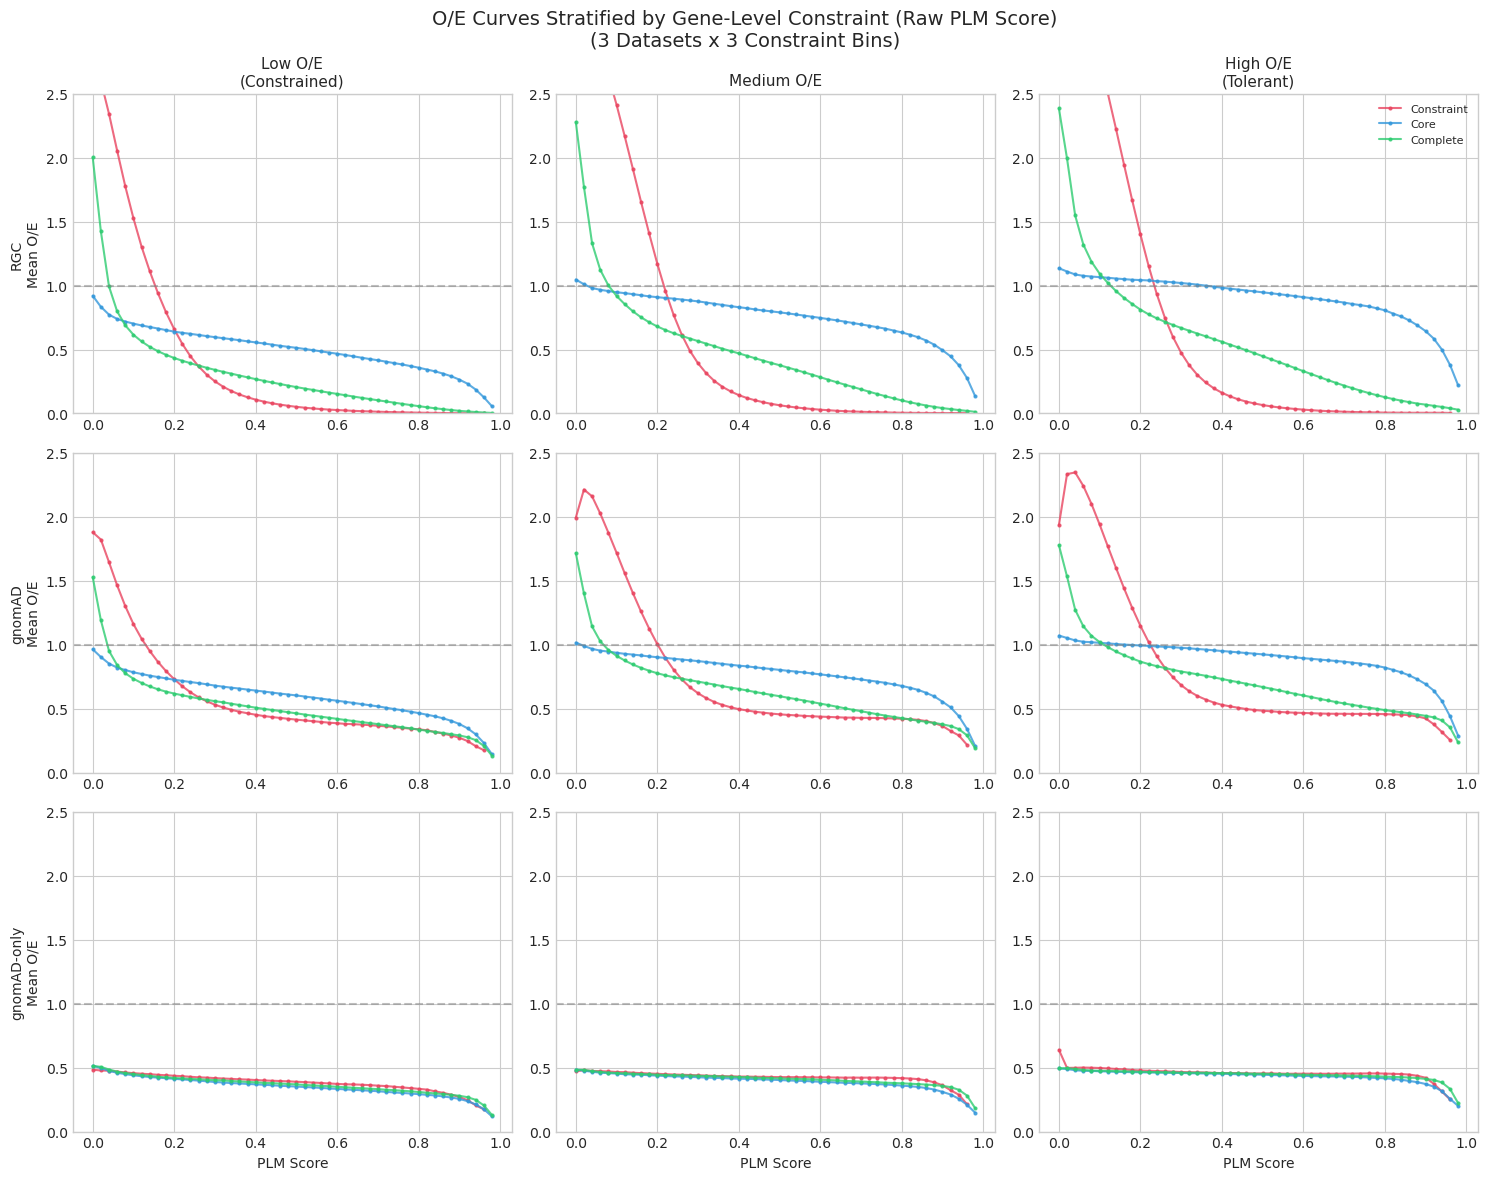


Interpretation:
- Low O/E genes (constrained): PLM should show stronger O/E signal (steeper curves)
- High O/E genes (tolerant): May show weaker signal (flatter curves)
- gnomAD-only validates generalization to unseen variants


In [31]:
# =============================================================================
# Figure 4: 3x3 Stratified Figure using Raw PLM Score (x-axis)
# =============================================================================
# Create 3x3 grid: 3 datasets (rows) x 3 O/E bins (columns)
# This shows how model performance varies by gene constraint level AND dataset

# Filter to raw PLM data only for this figure
eda_df_raw = eda_df_stratified.filter(pl.col('x_axis_type') == 'raw')

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

datasets = ['RGC', 'gnomAD', 'gnomAD-only']
oe_bins = ['Low O/E\n(Constrained)', 'Medium O/E', 'High O/E\n(Tolerant)']
models = ['Constraint', 'Core', 'Complete']
colors = {'Constraint': '#e94560', 'Core': '#3498db', 'Complete': '#2ecc71'}

for row, dataset in enumerate(datasets):
    for col, oe_bin in enumerate(oe_bins):
        ax = axes[row, col]
        
        for model in models:
            subset = eda_df_raw.filter(
                (pl.col('model') == model) &
                (pl.col('dataset') == dataset) &
                (pl.col('oe_bin_absolute') == oe_bin)  # Fixed: was 'oe_bin'
            )
            
            if subset.height == 0:
                continue
            
            avg_by_bin = subset.group_by('plm_bin').agg([
                pl.col('mean_oe').mean().alias('avg_oe')
            ]).sort('plm_bin')
            
            ax.plot(avg_by_bin['plm_bin'].to_numpy(), avg_by_bin['avg_oe'].to_numpy(),
                    '-o', markersize=2, label=model, color=colors[model], alpha=0.8)
        
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 2.5)
        
        # Labels
        if row == 0:
            ax.set_title(oe_bin, fontsize=11)
        if col == 0:
            ax.set_ylabel(f'{dataset}\nMean O/E', fontsize=10)
        if row == 2:
            ax.set_xlabel('PLM Score', fontsize=10)
        if row == 0 and col == 2:
            ax.legend(loc='upper right', fontsize=8)

plt.suptitle('O/E Curves Stratified by Gene-Level Constraint (Raw PLM Score)\n(3 Datasets x 3 Constraint Bins)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{BROWSER_OUTPUT_DIR}/eda_stratified_by_gene_oe.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nInterpretation:')
print('- Low O/E genes (constrained): PLM should show stronger O/E signal (steeper curves)')
print('- High O/E genes (tolerant): May show weaker signal (flatter curves)')
print('- gnomAD-only validates generalization to unseen variants')

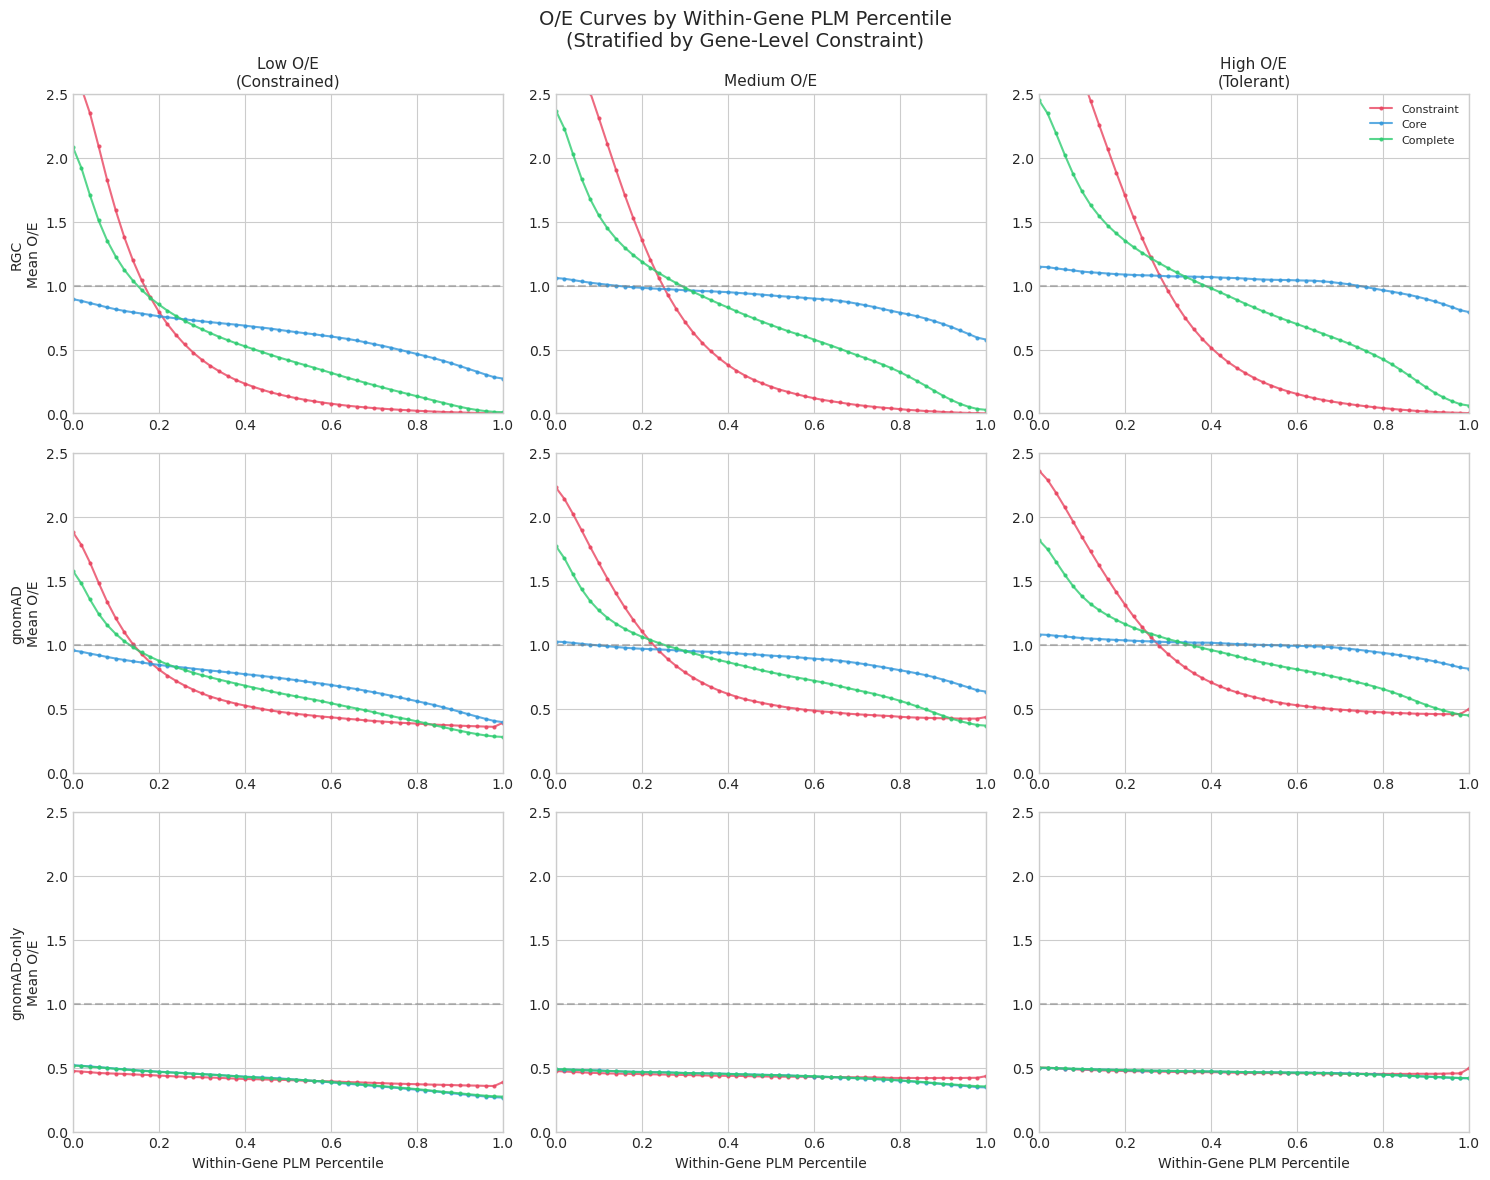


Interpretation:
- X-axis is now within-gene PLM percentile (0 = lowest PLM in gene, 1 = highest)
- This normalizes for gene-specific PLM score distributions
- Curves should be more comparable across genes with different PLM ranges


In [32]:
# =============================================================================
# Figure 5: 3x3 Stratified Figure using Within-Gene PLM Percentile (x-axis)
# =============================================================================
# Same structure as Figure 4, but x-axis is within-gene PLM percentile
# This normalizes for gene-specific PLM score distributions

# Filter to percentile-binned data only
eda_df_perc = eda_df_stratified.filter(pl.col('x_axis_type') == 'percentile')

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

datasets = ['RGC', 'gnomAD', 'gnomAD-only']
oe_bins = ['Low O/E\n(Constrained)', 'Medium O/E', 'High O/E\n(Tolerant)']
models = ['Constraint', 'Core', 'Complete']
colors = {'Constraint': '#e94560', 'Core': '#3498db', 'Complete': '#2ecc71'}

for row, dataset in enumerate(datasets):
    for col, oe_bin in enumerate(oe_bins):
        ax = axes[row, col]
        
        for model in models:
            subset = eda_df_perc.filter(
                (pl.col('model') == model) &
                (pl.col('dataset') == dataset) &
                (pl.col('oe_bin_absolute') == oe_bin)
            )
            
            if subset.height == 0:
                continue
            
            avg_by_bin = subset.group_by('plm_bin').agg([
                pl.col('mean_oe').mean().alias('avg_oe')
            ]).sort('plm_bin')
            
            ax.plot(avg_by_bin['plm_bin'].to_numpy(), avg_by_bin['avg_oe'].to_numpy(),
                    '-o', markersize=2, label=model, color=colors[model], alpha=0.8)
        
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 1)  # Percentile is always 0-1
        
        # Labels
        if row == 0:
            ax.set_title(oe_bin, fontsize=11)
        if col == 0:
            ax.set_ylabel(f'{dataset}\nMean O/E', fontsize=10)
        if row == 2:
            ax.set_xlabel('Within-Gene PLM Percentile', fontsize=10)
        if row == 0 and col == 2:
            ax.legend(loc='upper right', fontsize=8)

plt.suptitle('O/E Curves by Within-Gene PLM Percentile\n(Stratified by Gene-Level Constraint)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{BROWSER_OUTPUT_DIR}/eda_stratified_by_gene_oe_percentile.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nInterpretation:')
print('- X-axis is now within-gene PLM percentile (0 = lowest PLM in gene, 1 = highest)')
print('- This normalizes for gene-specific PLM score distributions')
print('- Curves should be more comparable across genes with different PLM ranges')

In [24]:
# Summary statistics table
summary_stats = eda_df.group_by(['model', 'dataset']).agg([
    pl.col('n_variants').sum().alias('total_variants'),
    pl.col('n_clinvar').sum().alias('total_clinvar'),
    pl.col('mean_oe').mean().alias('overall_mean_oe'),
    pl.col('transcript').n_unique().alias('n_genes')
]).sort(['model', 'dataset'])

print('\n=== Summary Statistics by Model and Dataset ===')
print(summary_stats)


=== Summary Statistics by Model and Dataset ===
shape: (9, 6)
┌────────────┬─────────────┬────────────────┬───────────────┬─────────────────┬─────────┐
│ model      ┆ dataset     ┆ total_variants ┆ total_clinvar ┆ overall_mean_oe ┆ n_genes │
│ ---        ┆ ---         ┆ ---            ┆ ---           ┆ ---             ┆ ---     │
│ str        ┆ str         ┆ u32            ┆ u32           ┆ f64             ┆ u32     │
╞════════════╪═════════════╪════════════════╪═══════════════╪═════════════════╪═════════╡
│ Complete   ┆ RGC         ┆ 144334682      ┆ 122878        ┆ 0.59919         ┆ 19133   │
│ Complete   ┆ gnomAD      ┆ 144226316      ┆ 122922        ┆ 0.72465         ┆ 19130   │
│ Complete   ┆ gnomAD-only ┆ 123337826      ┆ 88044         ┆ 0.426283        ┆ 19130   │
│ Constraint ┆ RGC         ┆ 144345336      ┆ 122924        ┆ 0.647311        ┆ 19133   │
│ Constraint ┆ gnomAD      ┆ 144201282      ┆ 122920        ┆ 0.762808        ┆ 19128   │
│ Constraint ┆ gnomAD-only ┆ 12331288

## Summary

Browser data generation complete! Output files:
- `oe_curves_binned.parquet`: Binned O/E curve data for all **18** model-dataset-x_axis combinations (9 raw + 9 percentile)
- `oe_curves_gene_summary.parquet`: Gene-level summary statistics

**New Feature: Within-Gene PLM Percentiles**
- Figure 4: 3x3 grid using raw PLM score as x-axis (9 panels)
- Figure 5: 3x3 grid using within-gene PLM percentile as x-axis (9 panels)
- Total: **18 panels** for comprehensive model evaluation

Key findings from EDA:
- [Model comparison insights will appear after running]
- [Dataset comparison insights will appear after running]
- [gnomAD-only validation insights will appear after running]
- [Within-gene percentile comparison insights will appear after running]

## Summary

Browser data generation complete! Output files:
- `oe_curves_binned.parquet`: Binned O/E curve data for all 9 model-dataset combinations
- `oe_curves_gene_summary.parquet`: Gene-level summary statistics

Key findings from EDA:
- [Model comparison insights will appear after running]
- [Dataset comparison insights will appear after running]
- [RGC-only validation insights will appear after running]